In [1]:
!pip install -r requirements.txt

In [7]:
import os
import warnings
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['LOKY_MAX_CPU_COUNT'] = '1'
warnings.filterwarnings('ignore')


In [9]:
def get_k_from_dendrogram(X_data, method='ward'):
    # 1. Compute Linkage Matrix
    Z = sch.linkage(X_data, method=method)
    
    # 2. Find the largest vertical gap (distance jump) to determine K automatically
    last_distances = Z[-15:, 2] 
    last_distances_sorted = np.sort(last_distances)[::-1] 
    
    gaps = np.diff(last_distances_sorted) 
    max_gap_index = np.argmin(gaps)
    
    # The optimal K is roughly the index + 2
    optimal_k = max_gap_index + 2
    
    return optimal_k, Z

In [13]:
# Load Data & Preprocessing
df = pd.read_csv('Mall_Customers.csv')

# Encode Genre (Male=0, Female=1)
le = LabelEncoder()
df['Genre_Code'] = le.fit_transform(df['Genre'])

target = 'Spending Score (1-100)'
feats_to_compare = ['Genre_Code', 'Age', 'Annual Income (k$)']
all_feats = feats_to_compare + [target]

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(df[all_feats])

Feature              | Best K | Time (s)  
---------------------------------------------
Genre_Code           | 2      | 0.00101
Age                  | 2      | 0.00100
Annual Income (k$)   | 5      | 0.00200


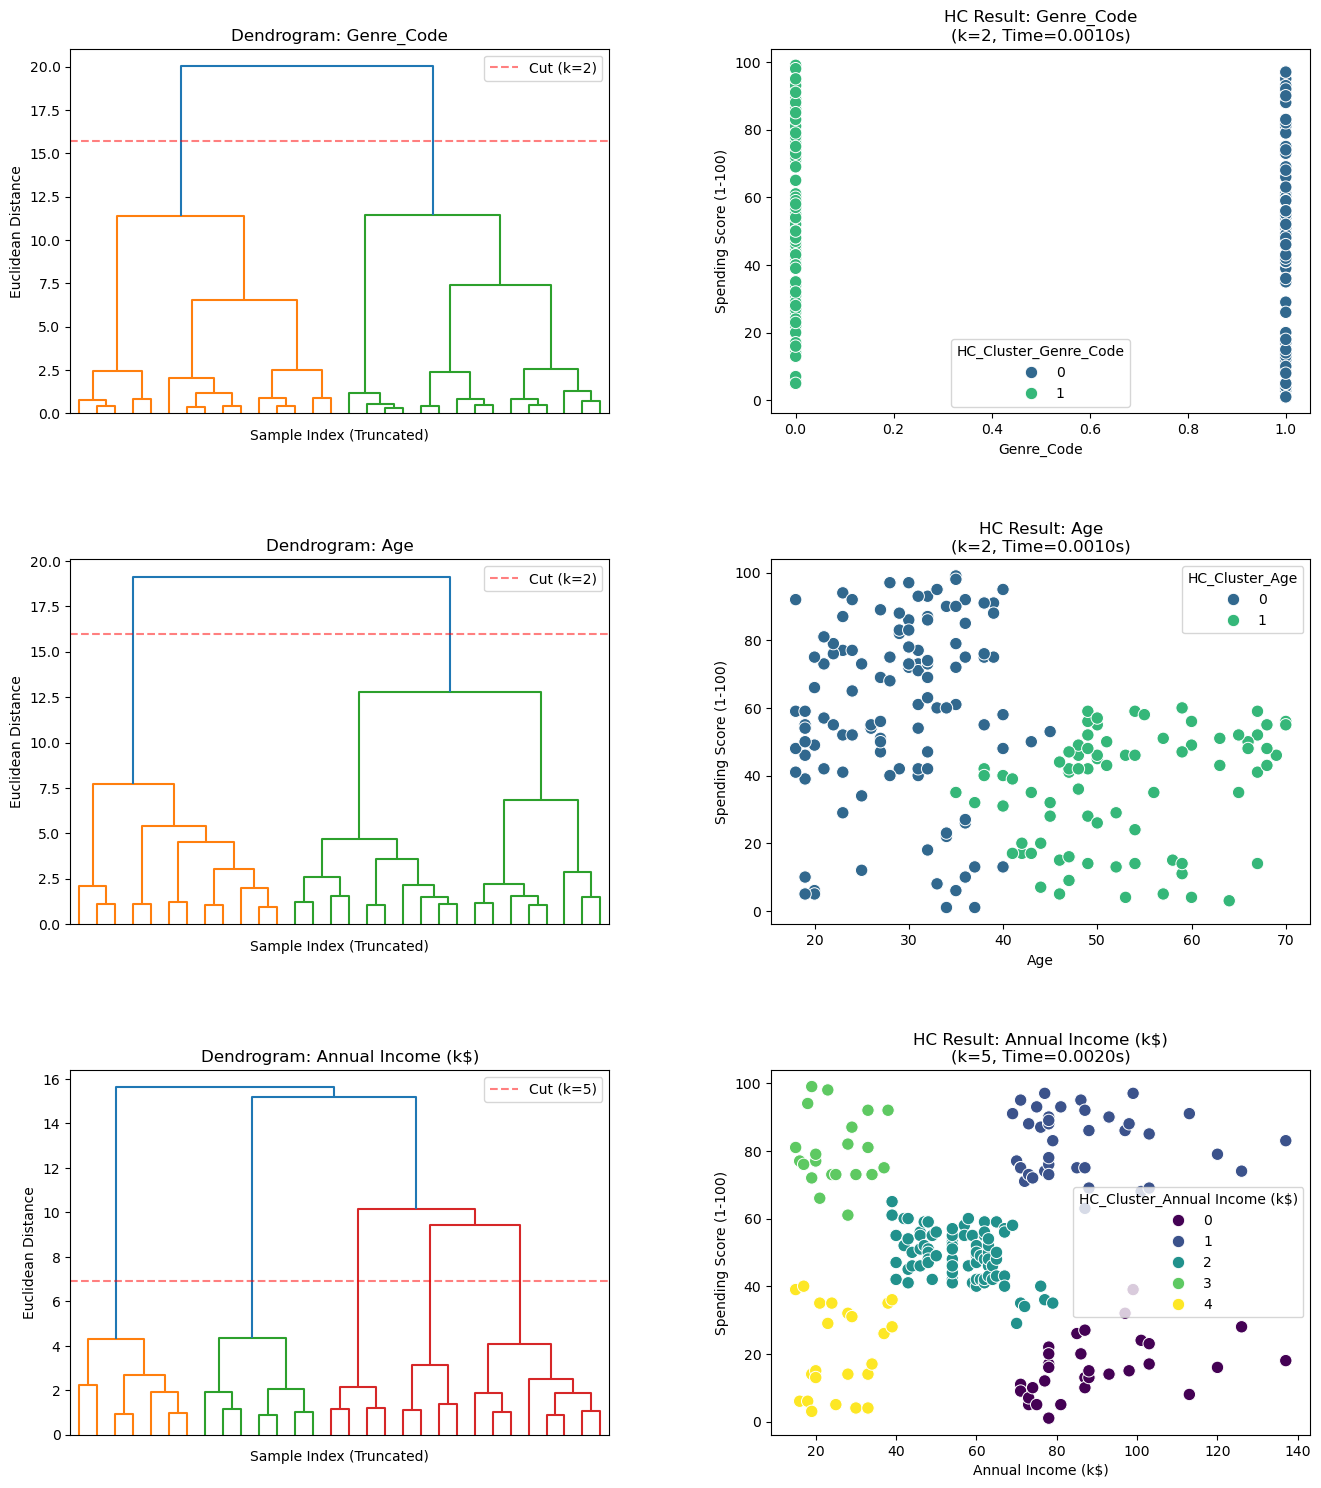

In [15]:
#Dendrograms & HC 
fig, axes = plt.subplots(len(feats_to_compare), 2, figsize=(16, 6 * len(feats_to_compare)))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

print(f"{'Feature':<20} | {'Best K':<6} | {'Time (s)':<10}")
print("-" * 45)

for i, feat in enumerate(feats_to_compare):
    # 1. Prepare Data
    X_pair = df[[feat, target]].values
    X_pair_scaled = scaler.fit_transform(X_pair)
    
    # 2. Compute Linkage & Find K 
    best_k, Z = get_k_from_dendrogram(X_pair_scaled)
    
    # 3. Run Agglomerative Clustering & Time it
    start = time.time()
    hc = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
    labels = hc.fit_predict(X_pair_scaled)
    elapsed = time.time() - start
    
    print(f"{feat:<20} | {best_k:<6} | {elapsed:.5f}")
    
    # --- Plot 1: Dendrogram ---
    ax_dendro = axes[i, 0]
    sch.dendrogram(Z, ax=ax_dendro, truncate_mode='lastp', p=30, show_leaf_counts=False)
    ax_dendro.set_title(f'Dendrogram: {feat}')
    ax_dendro.set_xlabel('Sample Index (Truncated)')
    ax_dendro.set_ylabel('Euclidean Distance')

    cut_height = (Z[-best_k, 2] + Z[-best_k+1, 2]) / 2
    ax_dendro.axhline(y=cut_height, c='r', ls='--', alpha=0.5, label=f'Cut (k={best_k})')
    ax_dendro.legend()
    
    # --- Plot 2: Scatter Plot ---
    ax_scatter = axes[i, 1]
    cluster_col = f'HC_Cluster_{feat}'
    df[cluster_col] = labels
    sns.scatterplot(x=df[feat], y=df[target], hue=df[cluster_col], 
                    palette='viridis', ax=ax_scatter, legend='full', s=80)
    ax_scatter.set_title(f'HC Result: {feat}\n(k={best_k}, Time={elapsed:.4f}s)')

plt.show()


Global Optimal K is 2
Global Clustering Execution Time: 0.0031 seconds


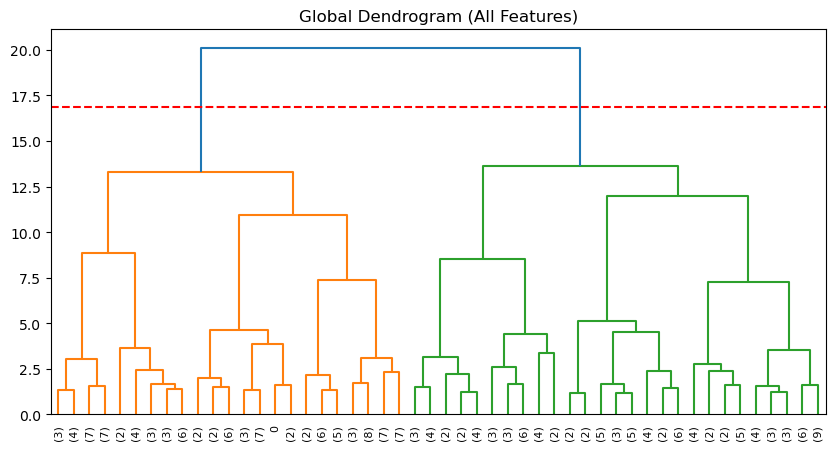

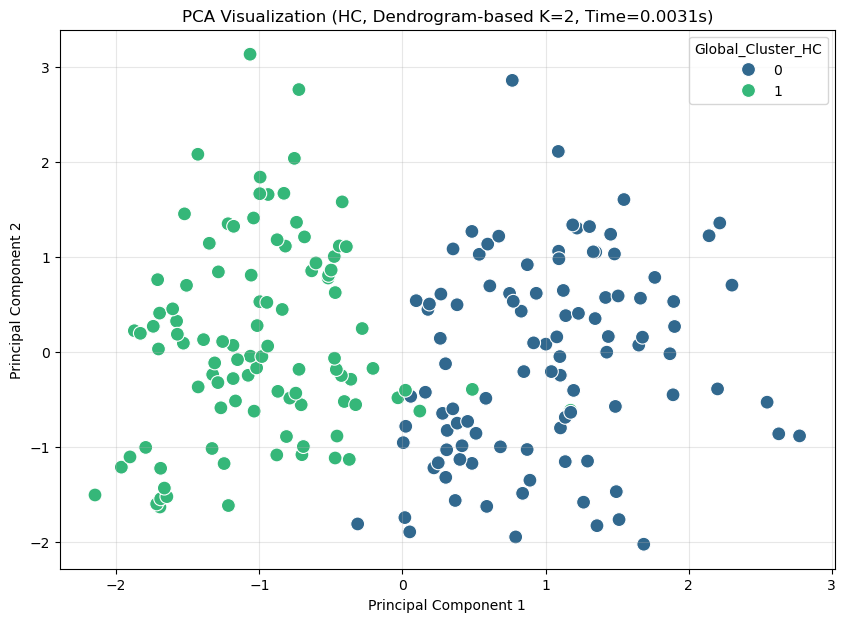

In [23]:
# Global Clustering & PCA
start_time = time.time()

# 1. Find Global K 
best_k_global, Z_global = get_k_from_dendrogram(X_all_scaled)
print(f"\nGlobal Optimal K is {best_k_global}")

# 2. Global HC
hc_global = AgglomerativeClustering(n_clusters=best_k_global, linkage='ward')
global_labels = hc_global.fit_predict(X_all_scaled)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Global Clustering Execution Time: {elapsed_time:.4f} seconds")

# 3. Global Dendrogram
plt.figure(figsize=(10, 5))
sch.dendrogram(Z_global, truncate_mode='lastp', p=50)
plt.title(f'Global Dendrogram (All Features)')
plt.axhline(y=(Z_global[-best_k_global, 2] + Z_global[-best_k_global+1, 2]) / 2, c='r', ls='--')
plt.show()

# 4. PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_scaled)

df['PCA_1'] = X_pca[:, 0]
df['PCA_2'] = X_pca[:, 1]
df['Global_Cluster_HC'] = global_labels

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Global_Cluster_HC', data=df, palette='viridis', s=100)

plt.title(f'PCA Visualization (HC, Dendrogram-based K={best_k_global}, Time={elapsed_time:.4f}s)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)
plt.show()